# Tutorial - MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunction
from MTMR.properties import drd2, qed, similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [5]:
PROPERTY_NAME = "drd2"
TEST_NUM = "10"

SCORING_PROPERTY_FT = drd2
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)

In [6]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_5-1_{PROPERTY_NAME.upper()}_pretraining_{TEST_NUM}"

In [7]:
output_dir = f"outputs_5-5_{PROPERTY_NAME.upper()}_finetuning_{TEST_NUM}"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [8]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [9]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [10]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [11]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [12]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [13]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Train

In [14]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         checkpoint_filepath=filepath_checkpoint)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000010/002000]  loss: 0.024  reward: 0.090  similarity: 0.744  property: 0.090  (9.6 min)
[000020/002000]  loss: 0.021  reward: 0.132  similarity: 0.702  property: 0.132  (18.8 min)
[000030/002000]  loss: 0.036  reward: 0.169  similarity: 0.596  property: 0.169  (28.5 min)
[000040/002000]  loss: 0.038  reward: 0.234  similarity: 0.567  property: 0.234  (39.3 min)
[000050/002000]  loss: 0.039  reward: 0.253  similarity: 0.540  property: 0.253  (50.7 min)
[000060/002000]  loss: 0.046  reward: 0.378  similarity: 0.525  property: 0.378  (62.8 min)
[000070/002000]  loss: 0.043  reward: 0.382  similarity: 0.511  property: 0.382  (74.9 min)
[000080/002000]  loss: 0.041  reward: 0.367  similarity: 0.521  property: 0.367  (87.2 min)
[000090/002000]  loss: 0.036  reward: 0.370  similarity: 0.513  property: 0.370  (100.0 min)
[000100/002000]  loss: 0.047  reward: 0.474  similarity: 0.497  property: 0.474  valid_ratio(va): 1.000  similarity(va): 0.349  property(va): 0.402  (120.4 min)
[000110/002

[000840/002000]  loss: 0.046  reward: 0.716  similarity: 0.426  property: 0.716  (1140.4 min)
[000850/002000]  loss: 0.048  reward: 0.692  similarity: 0.441  property: 0.692  (1152.6 min)
[000860/002000]  loss: 0.047  reward: 0.747  similarity: 0.436  property: 0.747  (1164.9 min)
[000870/002000]  loss: 0.050  reward: 0.688  similarity: 0.440  property: 0.688  (1177.7 min)
[000880/002000]  loss: 0.051  reward: 0.717  similarity: 0.452  property: 0.717  (1190.0 min)
[000890/002000]  loss: 0.047  reward: 0.712  similarity: 0.456  property: 0.712  (1202.5 min)
[000900/002000]  loss: 0.046  reward: 0.753  similarity: 0.443  property: 0.753  valid_ratio(va): 1.000  similarity(va): 0.307  property(va): 0.667  (1222.4 min)
[000910/002000]  loss: 0.052  reward: 0.736  similarity: 0.437  property: 0.736  (1236.0 min)
[000920/002000]  loss: 0.046  reward: 0.763  similarity: 0.427  property: 0.763  (1249.2 min)
[000930/002000]  loss: 0.050  reward: 0.756  similarity: 0.435  property: 0.756  (1262

[001660/002000]  loss: 0.045  reward: 0.801  similarity: 0.436  property: 0.801  (2234.0 min)
[001670/002000]  loss: 0.052  reward: 0.759  similarity: 0.418  property: 0.759  (2246.3 min)
[001680/002000]  loss: 0.047  reward: 0.783  similarity: 0.446  property: 0.783  (2259.2 min)
[001690/002000]  loss: 0.051  reward: 0.775  similarity: 0.442  property: 0.775  (2271.2 min)
[001700/002000]  loss: 0.051  reward: 0.807  similarity: 0.424  property: 0.807  valid_ratio(va): 1.000  similarity(va): 0.307  property(va): 0.700  (2291.6 min)
[001710/002000]  loss: 0.047  reward: 0.728  similarity: 0.442  property: 0.728  (2304.3 min)
[001720/002000]  loss: 0.048  reward: 0.813  similarity: 0.432  property: 0.813  (2316.2 min)
[001730/002000]  loss: 0.048  reward: 0.788  similarity: 0.444  property: 0.788  (2328.3 min)
[001740/002000]  loss: 0.048  reward: 0.788  similarity: 0.426  property: 0.788  (2340.5 min)
[001750/002000]  loss: 0.046  reward: 0.777  similarity: 0.429  property: 0.777  (2353

## 10. Visualize for reward & loss analysis

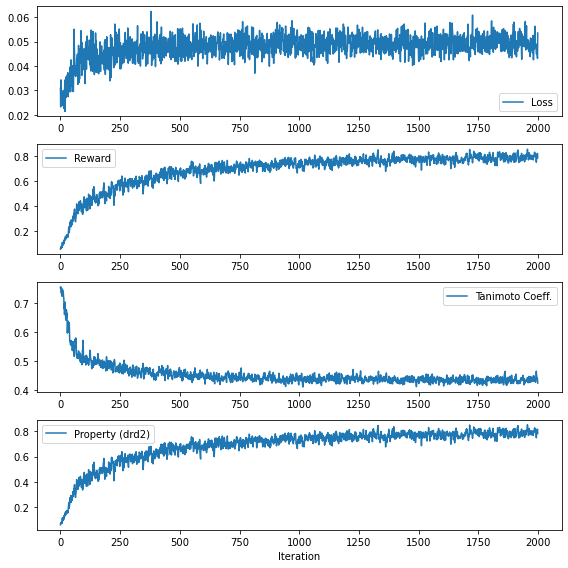

In [15]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

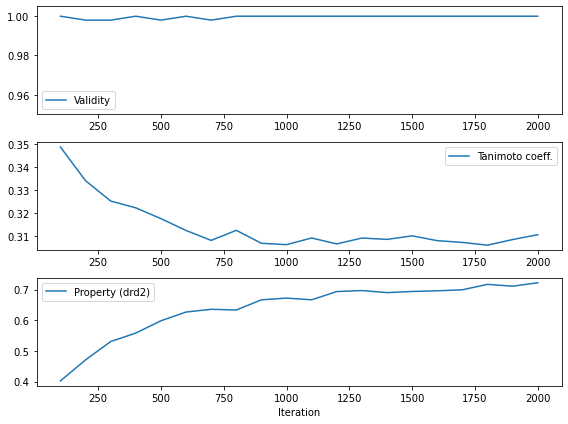

In [17]:
fig, axes = plt.subplots(3,1,figsize=(8,6))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()